# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

# Import dataset

In [3]:
file = 'Data.csv'
df = pd.read_csv(file, parse_dates = ['Date'], index_col = 'Date')
df

,Max Temp (C),Min Temp (C),Total Precip (mm),WC (m3/capita.day)
Date,,,,
2011-09-01,25.8,14.1,0.0,0.471092
2011-09-02,26.9,19.7,0.0,0.455604
2011-09-03,29.5,21.1,0.0,0.436626
2011-09-04,27.8,19.2,15.0,0.442867
2011-09-05,21.5,14.6,11.0,0.437708
...,...,...,...,...
2015-09-26,18.0,5.6,0.0,0.377468
2015-09-27,23.1,5.2,0.0,0.380783
2015-09-28,21.4,13.0,0.6,0.361291


# Data preprocessing

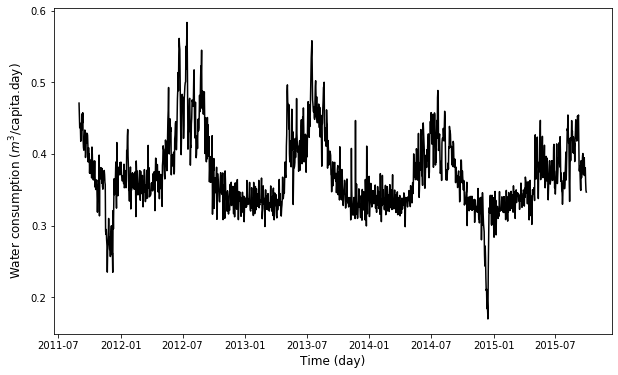

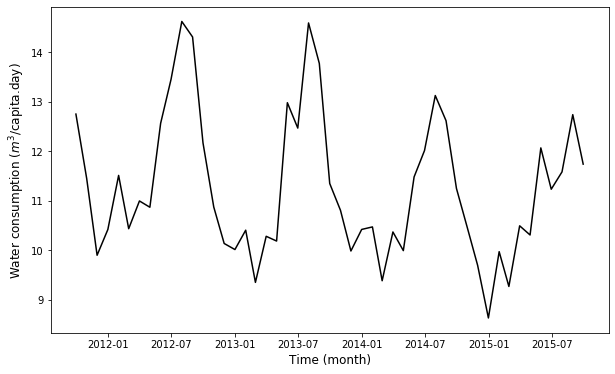

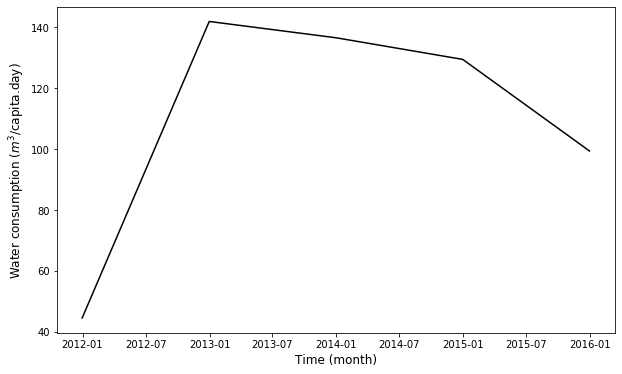

In [4]:
# Select the target
df = df.rename(columns = {'WC (m3/capita.day)':'WC'})

# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Water consumption ($m^3$/capita.day)', {'fontsize': 12})
    

dataset = df.copy()
timeseries(df.index, dataset['WC'], 'Time (day)')

dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['WC'], 'Time (month)')

dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['WC'], 'Time (month)')


In [5]:
# Check for missing values
df = df.loc[:,['Date','WC']]

print('Total num of missing values:') 
print(df.WC.isna().sum())
print('')

# Locate the missing value
df_missing_date = df.loc[df.WC.isna() == True]
print('The date of missing value:')
print(df_missing_date.loc[:,['Date']])

# Replcase missing value with interpolation
df.WC.interpolate(inplace = True)

df = df.drop('Date', axis = 1)

Total num of missing values:
1

The date of missing value:
            Date
Date            
2012-12-31   NaN


In [6]:
# Split train data and test data
train_size = int(len(df)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [7]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [8]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1162, 30, 1)
y_train.shape:  (1162, 1)
X_test.shape:  (269, 30, 1)
y_test.shape:  (269, 1)


In [9]:
X_test[:33].shape

(33, 30, 1)

# Create models

In [10]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2,
                    batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Train on 929 samples, validate on 233 samples
Epoch 1/10
929/929 [==============================] - 12s 12ms/sample - loss: 0.0188 - val_loss: 0.0125
Epoch 2/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0104 - val_loss: 0.0149
Epoch 3/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0111 - val_loss: 0.0120
Epoch 4/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0107 - val_loss: 0.0083
Epoch 5/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0094 - val_loss: 0.0083
Epoch 6/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0087 - val_loss: 0.0087 loss: 0 - ETA:
Epoch 7/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0085 - val_loss: 0.0070
Epoch 8/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0080 - val_loss: 0.0070
Epoch 9/10
929/929 [==============================] - 4s 4ms/sample - loss: 0.0076 - val_loss: 0.0064
Epoch 10/10
929/929

# Model performance

GRU:
Mean Absolute Error: 0.0222
Root Mean Square Error: 0.0277

Bidirectiona LSTM:
Mean Absolute Error: 0.0181
Root Mean Square Error: 0.0235



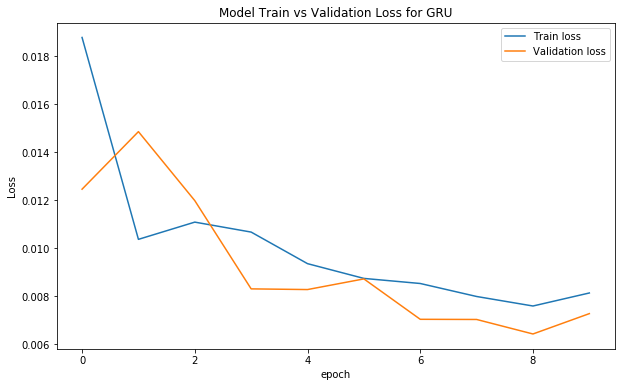

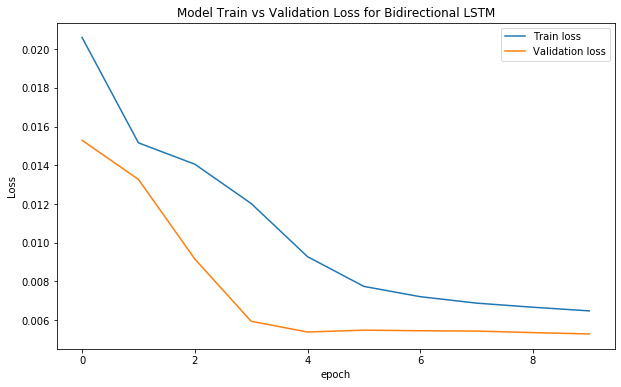

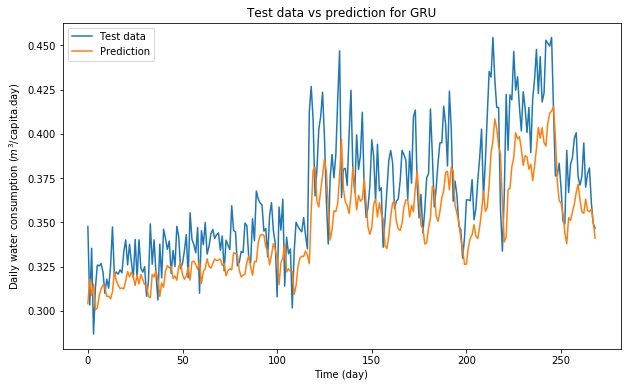

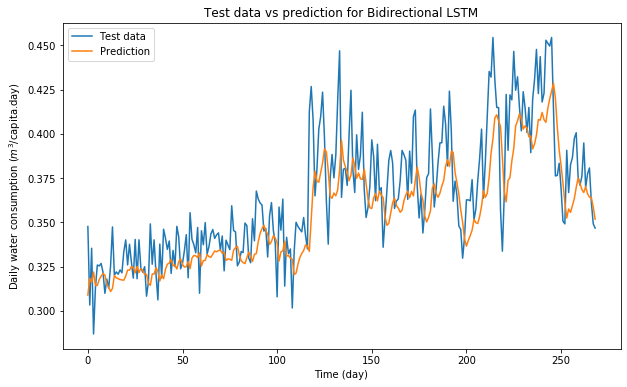

In [11]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('C:/Users/nious/Documents/Medium/Time series/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
       
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

# Multi-step forecasting

In [12]:
# Select 60 days of data from test data
new_data = test_data.iloc[100:160]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape) 

X_30.shape:  (30, 30, 1)


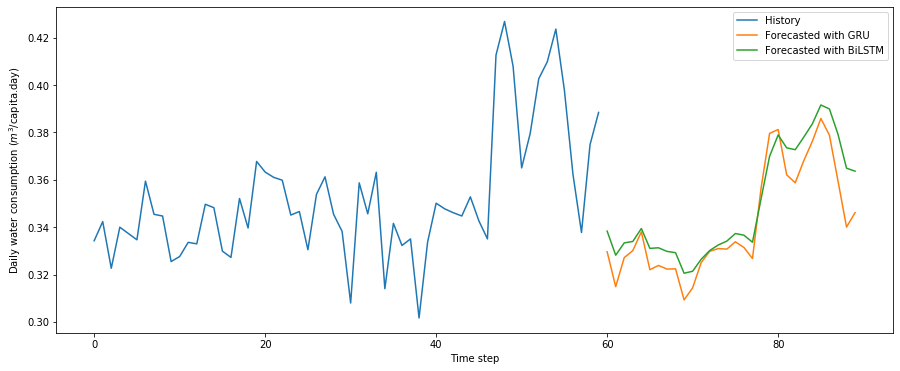

In [13]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

# Plot history and future
def plot_multi_step(history, prediction1, prediction2):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with GRU')
    plt.plot(range_future, np.array(prediction2),label='Forecasted with BiLSTM')
    
    plt.legend(loc='upper right')
    plt.xlabel('Time step')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
    
plot_multi_step(new_data, prediction_gru, prediction_bilstm)